# =======================
# = Glazsiou study | Transition plot =
# =======================

The purpose of this notebook is to produce a plot of the transitions between the combinations of state and test-status levels.

The notebook is coded entirely in R.

# Get requisite packages.

In [1]:
# Get requisite packages.
if( !"pacman" %in% installed.packages() )
{
  install.packages( "pacman" )
  libray( pacman )
}
pacman::p_load(
    bigrquery # Version ‘1.5.1’
    ,data.table # Version ‘1.16.0’
    ,GGally # Version ‘2.2.1’
    ,ggraph
    ,gtable # Version ‘0.3.6’
    ,grid # Version ‘4.4.1’
    ,gridExtra # Version ‘2.3’
    ,IRdisplay
    ,kableExtra
    ,paletteer # Version ‘1.6.0’
    ,readr # Version ‘2.1.5’
    ,tidytext # Version ‘0.4.2’
    ,tidyverse # Version ‘2.0.0’
    ,TraMineR # Version ‘2.2.10’
    ,TraMineRextras # Version ‘0.6.8’
)
#devtools::install_github("davidsjoberg/ggsankey")
#remove.packages("ggsankey")
devtools::install_github("ciaranmci/ggsankey", force = TRUE )

forcats (1.0.0 -> 1.0.1) [CRAN]


Installing 1 packages: forcats

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/var/tmp/RtmpfwZq1E/remotes144634cd2477/ciaranmci-ggsankey-821b0e3/DESCRIPTION’ ... OK
* preparing ‘ggsankey’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ggsankey_0.0.99999.tar.gz’



Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



# Set cohort parameters

In [2]:
# Study dates
# ## The date before which a patient must have had their diagnosis.
date_diagnosis_threshold <- lubridate::ymd('2000-01-01')
# ## The date after which test and intervention records will be studied.
followup_delay_in_years <- 0
date_followup_start <- date_diagnosis_threshold + lubridate::years( followup_delay_in_years )
# ## The date before which test and intervention records will be studied.
followup_duration_in_years <- 10
date_followup_end <- date_followup_start + lubridate::years( followup_duration_in_years )

# Set the duration of the window back in time to review prescriptions when identifying
# the HMA status.
HMA_adjust_lookBack_window <- lubridate::weeks( 16 )

# Set upper and lower thresholds for acceptable values of the test.
test_value_cutoff_lower <- 20
test_value_cutoff_upper <- 200

# Threshold for the expected interval between subsequent tests, in months
val_testing_interval_LB <- 2
val_testing_interval_UB <- 5

# Set values for meaningful changes in the values of the test.
val_meaningful_test_improvement <- -10
val_meaningful_test_disimprovement <- 10

# Set window within which to search for repeated (but not repeat) prescriptions.
window_repeated_prescription_months <- 3

# Set number of tests, treatments, or iterations after diagnosis that should be tracked.
n_iterations <- followup_duration_in_years*2

# Set the window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months.
multimorb_inclusion_window_months <- 60

# Set the window outwith which at least two mutimorbidity diagnoses must be of each other, in months.
multimorb_gap_window_months <- 1

# Generate the cohort.

In [3]:
source('RESHAPE_cohort_generator.r')

Warning message:
“The `check_from` argument of `tbl_sql()` is deprecated as of dbplyr 2.5.0.
ℹ The deprecated feature was likely used in the dbplyr package.
  Please report the issue at <https://github.com/tidyverse/dbplyr/issues>.”
Warning message:
“Missing values are always removed in SQL aggregation functions.
Use `na.rm = TRUE` to silence this warning
This warning is displayed once every 8 hours.”


# Format the data.

In [4]:
source('RESHAPE_format_the_data.r')

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


# Create STS objects.

In [5]:
source('RESHAPE_create_STS_objects.r')

# Summary of parameter values.

In [6]:
paste( date_diagnosis_threshold,": The date before which a patient must have had their diagnosis." )
paste( followup_delay_in_years,": The follow-up delay, in years." )
paste( followup_duration_in_years,": The follow-up duration, in years." )
paste( date_followup_start,": The date after which test and intervention records will be studied." )
paste( date_followup_end,": The date before which test and intervention records will be studied." )
paste( HMA_adjust_lookBack_window, ": The duration of the window, backward in time, to review prescriptions when identifying the state of the inter-test period.")
paste( test_value_cutoff_lower,": Lower threshold for acceptable values of the test." )
paste( test_value_cutoff_upper,": Upper threshold for acceptable values of the test." )
paste( window_repeated_prescription_months, ": The window within which to search for repeated (but not repeat) prescriptions.")
paste( n_iterations,": Number of tests, treatments,or iteration after diagnosis that should be tracked." )
paste( multimorb_inclusion_window_months,": The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months." )
paste( multimorb_gap_window_months,": The window outwith which at least two mutimorbidity diagnoses must be of each other, in months." )


[1] "2000-01-01 : The date before which a patient must have had their diagnosis."

[1] "0 : The follow-up delay, in years."

[1] "10 : The follow-up duration, in years."

[1] "2000-01-01 : The date after which test and intervention records will be studied."

[1] "2010-01-01 : The date before which test and intervention records will be studied."

[1] "112d 0H 0M 0S : The duration of the window, backward in time, to review prescriptions when identifying the state of the inter-test period."

[1] "20 : Lower threshold for acceptable values of the test."

[1] "200 : Upper threshold for acceptable values of the test."

[1] "3 : The window within which to search for repeated (but not repeat) prescriptions."

[1] "20 : Number of tests, treatments,or iteration after diagnosis that should be tracked."

[1] "60 : The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months."

[1] "1 : The window outwith which at least two mutimorbidity diagnoses must be of each other, in months."

# Playing around with a transition diagram

In [11]:
a <- 
    sts_seqmine_HMAandTestStatus %>%
    # Remove the default start node.
    dplyr::select( - last_col(), -a2 ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings() %>%
    dplyr::filter( node != "Unobserved", next_node != "Unobserved" )

In [12]:
transition_probabilities <-
    a %>%
    dplyr::group_by( node, next_node ) %>%
    dplyr::reframe( n = n() ) %>%
    dplyr::ungroup() %>%
    dplyr::mutate(
        trans_prob = round( n / sum(n), 2 )
    ) %>%
    dplyr::select( -n ) %>%
    dplyr::arrange( -trans_prob )

In [13]:
visit_count <-
    sts_seqmine_HMAandTestStatus %>%
    tidyr::pivot_longer( cols = starts_with( "a" ) ) %>%
    dplyr::filter( value != "Unobserved" ) %>%
    dplyr::group_by( value ) %>%
    dplyr::summarise( visit_count_for_combined = n() ) %>%
    dplyr::arrange( -visit_count_for_combined )

In [14]:
counts_and_transitions <-
    transition_probabilities %>%
    dplyr::left_join(
        visit_count
        ,by = join_by( node == value )
    )

In [15]:
plot_data <-
    counts_and_transitions %>%
    dplyr::mutate( combined = node, rn = row_number() ) %>%
    tidyr::separate_wider_delim(
        cols = node
        ,delim = " "
        ,names = c( "from_State", "from_TestStatus" )
    ) %>%
    tidyr::separate_wider_delim(
        cols = next_node
        ,delim = " "
        ,names = c( "to_State", "to_TestStatus" )
    ) %>%
    tidyr::pivot_longer(
        cols = ends_with( "State")
        ,names_to = "state_direction"
        ,values_to = "State"
    ) %>%
    tidyr::pivot_longer(
        cols = ends_with( "TestStatus")
        ,names_to = "testStatus_direction"
        ,values_to = "TestStatus"
    ) %>%
    dplyr::filter( substr(state_direction, 1, 2) == substr(testStatus_direction, 1, 2) ) %>%
    dplyr::mutate(
        plot_State = factor( State, levels = c( 'Hold', 'Monitor', 'Adjust') ) %>% as.integer()
        ,plot_TestStatus = factor( TestStatus, levels = c( 'Red', 'Amber', 'Yellow', 'Green' ) ) %>% as.integer()
    )

print( "The first 5 rows of the table of transition probabilities.")
head(plot_data, 5)

[1] "The first 5 rows of the table of transition probabilities."


trans_prob,visit_count_for_combined,combined,rn,state_direction,State,testStatus_direction,TestStatus,plot_State,plot_TestStatus
<dbl>,<int>,<fct>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
0.06,4199,Hold Green,1,from_State,Hold,from_TestStatus,Green,1,4
0.06,4199,Hold Green,1,to_State,Hold,to_TestStatus,Green,1,4
0.06,5016,Monitor Red,2,from_State,Monitor,from_TestStatus,Red,2,1
0.06,5016,Monitor Red,2,to_State,Monitor,to_TestStatus,Red,2,1
0.05,5182,Hold Yellow,3,from_State,Hold,from_TestStatus,Yellow,1,3


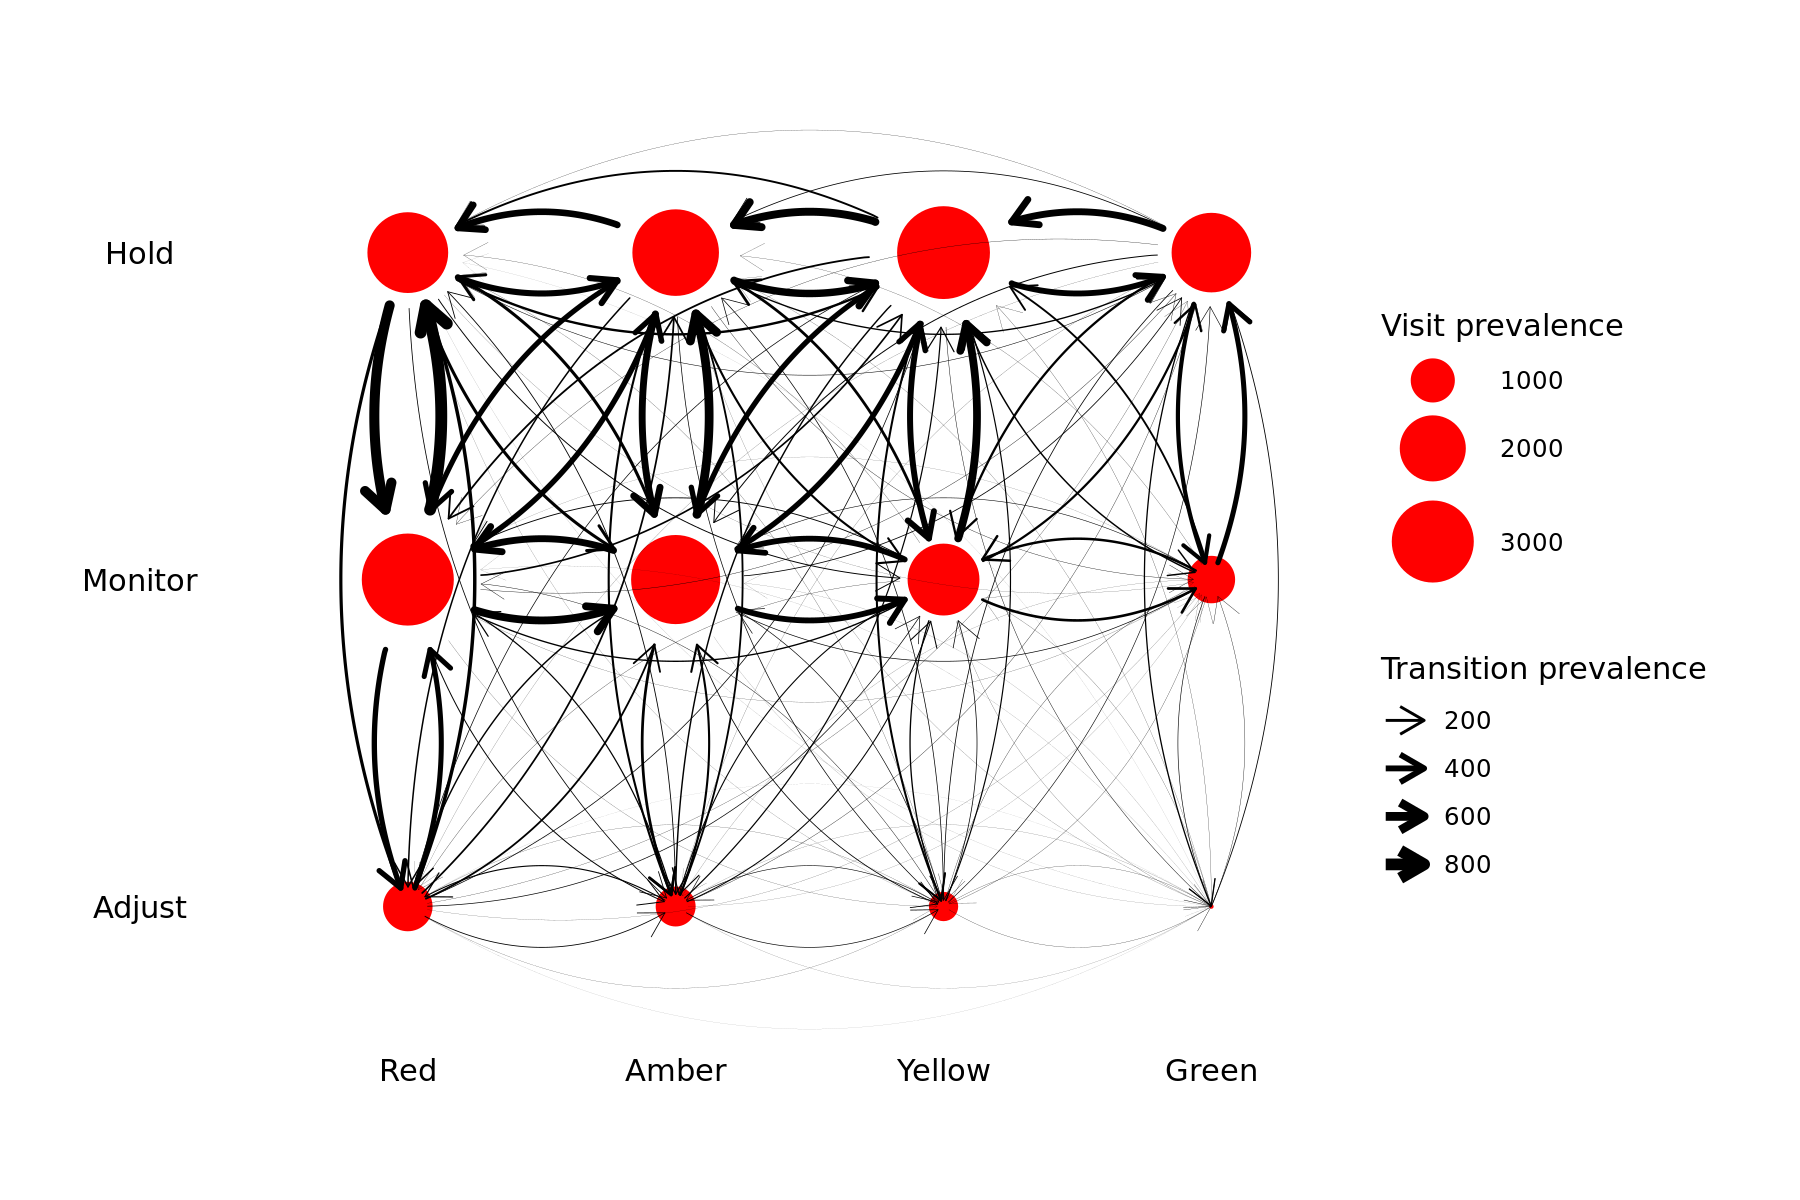

In [124]:
# Set display options.
options( repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 200 )
# Set plotting range of node size.
node_size_range <- c( 0.1, 15 )

my_nodes <- 
    a %>%
    dplyr::group_by( next_node ) %>%
    dplyr::reframe( `Visit prevalence` = n() ) %>%
    dplyr::ungroup() %>%
    dplyr::rename( name = next_node ) %>%
    dplyr::mutate(
        x = rep( 1:4, 3 )
        ,y = c( rep( 3, 4 ), rep( 2, 4 ), rep( 1, 4 ) )
    )

my_edges <-
    a %>%
    dplyr::group_by( node, next_node )%>%
    dplyr::reframe( `Transition prevalence` = n () ) %>%
    dplyr::ungroup() %>%
    dplyr::rename( from = node, to = next_node ) %>%
    dplyr::mutate( from = as.character( from ), to = as.character( to ) ) %>%
    dplyr::left_join(
        dplyr::select( my_nodes, name, `Visit prevalence` )
        ,by = join_by( from == name )
    ) %>%
    dplyr::rename( start_prevalence = `Visit prevalence`) %>%
    dplyr::left_join(
        dplyr::select( my_nodes, name, `Visit prevalence` )
        ,by = join_by( to == name )
    ) %>%
    dplyr::rename( end_prevalence = `Visit prevalence` ) %>%
    dplyr::mutate(
        norm_start_prevalence = ( start_prevalence - min( start_prevalence ) ) / diff( range( start_prevalence ) )
        ,norm_start_prevalence = norm_start_prevalence * diff( node_size_range ) + node_size_range[1]
        ,norm_end_prevalence = ( end_prevalence - min( end_prevalence ) ) / diff( range( end_prevalence ) )
        ,norm_end_prevalence = norm_end_prevalence * diff( node_size_range ) + node_size_range[1]
    )

my_labels <-
    data.frame(
        label = c( 'Hold', 'Monitor', 'Adjust', 'Red', 'Amber', 'Yellow', 'Green')
        ,x = c( rep( 0, 3 ), 1:4)
        ,y = c(  3:1, rep( 0.5, 4) )
    )

my_graph <-
    tidygraph::tbl_graph(
            nodes = my_nodes
            ,edges = my_edges
        ) %>%
    ggraph::ggraph( x = x, y = y ) +
    ggraph::geom_node_point( aes( size = `Visit prevalence` ), colour = 'red' ) +
    scale_size( range = c( .1, 15 ) ) +
    ggraph::geom_edge_fan(
        aes(
            start_cap = ggraph::circle( my_edges$norm_start_prevalence * 1.8, "pt" )
            ,end_cap = ggraph::circle( my_edges$norm_end_prevalence * 1.8, "pt" )
            ,width = `Transition prevalence`
        )
        ,lineend = 'round'
        ,arrow = grid::arrow( length = unit( 10, "points" ) )
        ,strength = 2 # use 0.6 if using `geom_edge_bend()`
    ) +
    ggraph::scale_edge_width( range = c( 0.001, 2 ) ) +
    ggplot2::geom_text(
        data = my_labels
        ,aes( label = label, x = x, y = y )
    ) +
    ggraph::theme_graph()

suppressWarnings( print( my_graph ) )
# Lots of help from the first FAQ, here: https://schochastics.github.io/netVizR/#FAQ

My comments on the plot above are:

1. Reciprocal transitions are always similar but not exact.
2. The busiest activity is between the Hold and Monitor states when the test status is Red or Amber.